In [1]:
#%%


import logging
import copy
from pathlib import Path
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor



import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger



import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import optim


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#%%


akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")
futures_client = Client(key = akey, secret= asec)

#%%

#DATA PARAMETERS

PREFIX = os.getcwd()
BLOCK = 512
DUMP = '.csv'
DATA_DIR = os.path.join(PREFIX, "datasets")

#%%

TIMEFRAME = "12h"
PAIR = "ETHUSDT"
# FROM_DATE = "2022-01-14 01:00:00" 
# TO_DATE = "2022-10-05 01:00:00"
FROM_DATE = "2022-06-01" 
TO_DATE = "2022-10-17"
NUM_DATA = 1000 #max 100k idk why

#%%

###

#PARAMETERS

DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

###

dir_name = f"{NUM_DATA}_{PAIR}_{TIMEFRAME}_{FROM_DATE.replace(' ', '-').replace(':', '')}_{TO_DATE.replace(' ', '-').replace(':', '')}"

NEW_DATA_DIR = os.path.join(PREFIX, DATA_DIR, dir_name)

if not os.path.exists(NEW_DATA_DIR):
    os.makedirs(NEW_DATA_DIR)
print(NEW_DATA_DIR)    


import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



/home/istrozzi/.cloned/trailing_orders/DEV/datasets/1000_ETHUSDT_12h_2022-06-01_2022-10-17


In [2]:
class StaticDatabase(Dataset):
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1000, seq_len=7, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform
        
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.seq_len = seq_len
        self.from_date = pd.Timestamp(from_date)
        self.to_date = pd.Timestamp(to_date)        
        self.from_ts = round(datetime.timestamp(pd.to_datetime(self.from_date, unit="ms")))*1000
        self.to_ts = round(datetime.timestamp(pd.to_datetime(self.to_date, unit="ms")))*1000
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit)) 
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['close_time'], unit='ms')))   
        self.last_ts = self.data.iloc[-1]['timestamp']   
        self.length = len(self.data)
        # self.data = pd.DataFrame()
        self.test = False
        self.train = True
    def __len__(self):
        return len(self.features)
    def __train__(self):
        self.test = False
    def __test__(self):
        self.train = False
    def __getitem__(self, idx, test=False):

        if test:
            feature = self.test_seqs[idx]
            label = self.test_tgt_seqs[idx]
        else:
            feature = self.train_seqs[idx]
            label = self.train_tgt_seqs[idx]
        
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

    def get_historical_klines(self):

        # print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
            
            if self.length % 1000 == 0: print(self.last_ts < self.to_ts)
            # print(1)
            print(self.data.shape)        
            self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))
            self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
            self.length = len(self.data)
            # print(self.data.iloc[-1]['timestamp'] > self.last_ts)
            self.last_ts = self.data.iloc[-1]['timestamp']
            
        # print(self.last_ts < self.to_ts)

        # self.dump_data()                    
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['timestamp'] = df['open_time']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        # df.drop(['close_time'], axis=1, inplace=True)
        return df

    def make_features_and_labels(self):


        df = self.data
        
        D = 1
        t = 1
        win1 = signal.windows.hann(9)
        win2 = signal.windows.hann(6)
        
        ###

        #FEATURES
        
        df["closes_ema"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        df["closes_std"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
        df["closes_z"] = (df.close - df.closes_ema) / df.closes_std
        df["closes_z"] = df.closes_z.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        
        df['sup_band'] = df.closes_ema + 1.618*df.closes_std
        df['inf_band'] = df.closes_ema - 1.618*df.closes_std
        df['band_cross'] = np.where(df.close > df.sup_band, 1, np.where(df.close < df.inf_band, -1, 0))

        ###
        
        features = self.data[
            ['timestamp', 'open_time', 'open', 'high', 'low', 'close', 'volume',
             'quote_asset_volume', 'trades', 'taker_buy_volume',
              'taker_buy_quote_asset_volume', 'closes_ema', 'closes_std',
               'closes_z']
              ]

        self.features = features
        ###
        # self.features["closes_ema_2"] = df.closes_ema.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        # self.features["filtered_closes_1"] = signal.convolve(self.features.close, win1, mode='same') / sum(win1)
        # self.features["filtered_closes_2"] = signal.convolve(self.features.close, win2, mode='same') / sum(win2)

        ###

        closes_1 = self.data.close.diff(periods=-1)
        closes_2 = self.data.close.diff(periods=-2)
        
        acc = ((self.features.close - closes_1) - (closes_1 - closes_2))/(D**2*t)
        self.features['acc'] = acc #this is pretty much noise
        self.features['filtered_acc'] = signal.convolve(self.features.acc, win2, mode='same') / sum(win2)
        self.features['filtered_acc'] = signal.convolve(self.features.acc, win1, mode='same') / sum(win1)
        
        ###

        filtered_z = signal.convolve(self.features.closes_z, win2, mode='same') / sum(win2)
        filtered_z = signal.convolve(self.features.closes_z, win1, mode='same') / sum(win1)
        self.features["filtered_z"] = filtered_z

        ###



        ###

        #LABELS
        
        mean_std = df.closes_std.mean()

        # peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
        # peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
        peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
        peak_regions = []
        
        for peak_index in peak_indexes:

            peak_regions.append(peak_index)

            for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if peak_index+j > len(df.close):
                    break
                elif peak_index-j < 0:
                    break
                
                if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/3:

                    peak_regions.append(peak_index-j)
                elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/3:
                    peak_regions.append(peak_index+j)        



        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
        valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
        valley_regions = []
        
        for valley_index in valley_indexes:
            # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
            valley_regions.append(valley_index)
            for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if valley_index+j > len(df.close):
                    break
                elif valley_index-j < 0:
                    break

                if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index-j)
                    
                elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index+j)
                        
        labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
        labels = pd.DataFrame(labels, columns=['labels'])
        
        self.labels = labels
        self.valleys = labels < 0
        self.valleys.rename(columns={"labels": "valleys"}, inplace=True)
        self.peaks = labels > 0
        self.peaks.rename(columns={"labels": "peaks"}, inplace=True)
        self.peak_regions = self.labels[self.labels == 1].dropna().index.values
        self.valley_regions = self.labels[self.labels == -1].dropna().index.values
        self.neutral_regions = self.labels[self.labels == 0].dropna().index.values        
        # df['peak_regions'] = peak_regions
        # df['valley_regions'] = valley_regions
        # self.data_alchemy()
        feat_labels = pd.concat([self.features, self.labels], axis=1)
        feat_labels.dropna(inplace=True)
        feat_labels.reindex(range(len(self.features)))
        self.features = feat_labels.drop(columns=['labels'])
        self.labels = feat_labels['labels']
        test_data_size = int(0.2 * self.length)
        data = self.features.drop(columns=['open_time', 'timestamp'])
        labels = self.labels
        std_data = (data -  data.mean())/data.std()

        
        self.train_data = std_data[:-test_data_size]
        self.test_data = std_data[-test_data_size:]

        self.train_labels = labels[:-test_data_size]
        self.test_labels = labels[-test_data_size:]

        
        ### TRAINING DATA

        self.train_seqs = self.make_train_sequences(self.train_data)
        self.test_seqs = self.make_train_sequences(self.test_data)

        self.train_tgt_seqs = self.make_target_sequences(self.train_labels)
        self.test_tgt_seqs = self.make_target_sequences(self.test_labels)
        print(self.train_seqs.shape)
        print(self.train_tgt_seqs.shape)



    def data_alchemy(self, *args, **kwargs):
        
        #FEATURE ENGINEERING
        
        df = self.data
        feat = self.features
        lab = self.labels

        self.data_alchemy(df, feat, lab)
        

    def make_train_sequences(self, iter, n=7):
        print(iter)
        sequences = []
        for j in range(len(iter)):
            if j-n < 0:
                continue
                sequences.append(None)
            elif j + (3) < len(iter):
                sequences.append(iter[j-7:j].values)           
            else:
                continue
                sequences.append(None)
                
        return np.array(sequences)[n:-3]
        #FEATURE ENGINEERING
    def make_target_sequences(self, iter, n=3):
        print(iter)
        sequences = []
        for j in range(len(iter)):
            if j-7 < 0:
                continue
                sequences.append(None)
            elif j + (n) < len(iter):             
                sequences.append(iter[j:j+(n)].values)
            else:
                continue
                sequences.append(None)
        return np.array(sequences)[7:-(n)]        

        

    def plot_data(self, figsize = (20, 16)):
        interval = self.length//10
        df = self.data
        
        # df = self.data[0:size]

        (fig1, ax1) = plt.subplots(figsize=figsize)

        ax1.plot('open_time', 'closes_ema', "r--", data = df)
        ax1.plot('open_time', 'close', "k-", data = df)
        # ax1.set_ylabel(r'Closes EMA [\$]')

        ax1.plot('open_time', 'inf_band', "r--", linewidth=0.75, data=df)
        ax1.plot('open_time', 'sup_band', "g--", linewidth=0.75, data=df)
        

        # Date-label the x ticks
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2*interval))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        # Rotates and right-aligns the x labels so they don't crowd each other.
        for label in ax1.get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
        ax1.grid(True)                    





        (fig2, ax2) = plt.subplots(figsize=figsize)

        ax2.plot(df.close, 'k-')
       
              
        
        peak_x = self.peak_regions
        peak_y = df.close.values[self.peak_regions]
        ax2.plot(peak_x, peak_y, marker='o', markersize=3.2, alpha=1, linestyle="None", color='green', label="Peaks")

        valley_x = self.valley_regions
        valley_y = df.close.values[self.valley_regions]
        ax2.plot(valley_x, valley_y, marker='o', markersize=3.2, alpha=1, linestyle="None", color='red', label="Valleys")
        ax2.grid(True, which="both")


        

        (fig3, axs) = plt.subplots(nrows=2, ncols=1, figsize=figsize)


        axs[0].plot('open_time', 'filtered_acc', "k-", data = self.features)
        # axs[0].plot('open_time', 'acc', "r--", data = self.features)

        axs[0].set_ylabel(r'Filtered Price Acceleration[\$]')

        # axs[0].plot(df.closes_ema - 1.618*df.closes_std, "r--", linewidth=0.75)
        # axs[0].plot(df.closes_ema + 1.618*df.closes_std, "g--", linewidth=0.75)

        # Date-label the x ticks
        axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=2*interval))
        axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        # Rotates and right-aligns the x labels so they don't crowd each other.
        for label in axs[0].get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
            
        axs[0].grid(True)  
               
       
        axs[1].plot('open_time', 'filtered_z', "k-", data = self.features)
        # axs[1].plot('open_time', 'closes_z', "r--", alpha=0.6, data = self.features)

        axs[1].set_ylabel(r'Filtered Z [\$]')

        # axs[1].plot(df.closes_ema - 1.618*df.closes_std, "r--", linewidth=0.75)
        # axs[1].plot(df.closes_ema + 1.618*df.closes_std, "g--", linewidth=0.75)

        # Date-label the x ticks
        axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=2*interval))
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        # Rotates and right-aligns the x labels so they don't crowd each other.
        for label in axs[1].get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
            
        axs[1].grid(True) 
        DUMP=False
        if DUMP:
            self.dump_data()
        
        return (fig1, ax1), (fig2, ax2), (fig3, axs)


    def dump_data(self, dir_name=None):
        if DUMP == '.json':
            self.features.to_json(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}.json"))
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.json")) 
        elif DUMP == '.csv':
            self.features.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_features.csv"))    
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.csv")) 

In [3]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


         open      high       low     close    volume  quote_asset_volume  \
26  -1.065107 -0.809091 -0.991164 -0.926877  0.768668            0.270972   
27  -0.923289 -0.960888 -1.597164 -1.297859  2.409526            1.225834   
28  -1.293700 -0.889374 -1.470463 -0.809217  3.378751            2.053290   
29  -0.805865 -0.856891 -1.261240 -1.336787  0.371389           -0.107273   
30  -1.332480 -1.299435 -1.437202 -1.513924  0.858167            0.130551   
..        ...       ...       ...       ...       ...                 ...   
225 -0.773674 -0.629587 -0.659901 -0.512248  0.103596           -0.150124   
226 -0.509344 -0.475855 -0.595227 -0.436482  1.844329            1.347518   
227 -0.433703 -0.437237 -0.467938 -0.597580  0.356823            0.143440   
228 -0.594535 -0.518673 -0.554281 -0.432764  2.272585            1.709193   
229 -0.429991 -0.527895 -0.345184 -0.434477 -0.971191           -0.995965   

       trades  taker_buy_volume  taker_buy_quote_asset_volume  closes_ema  

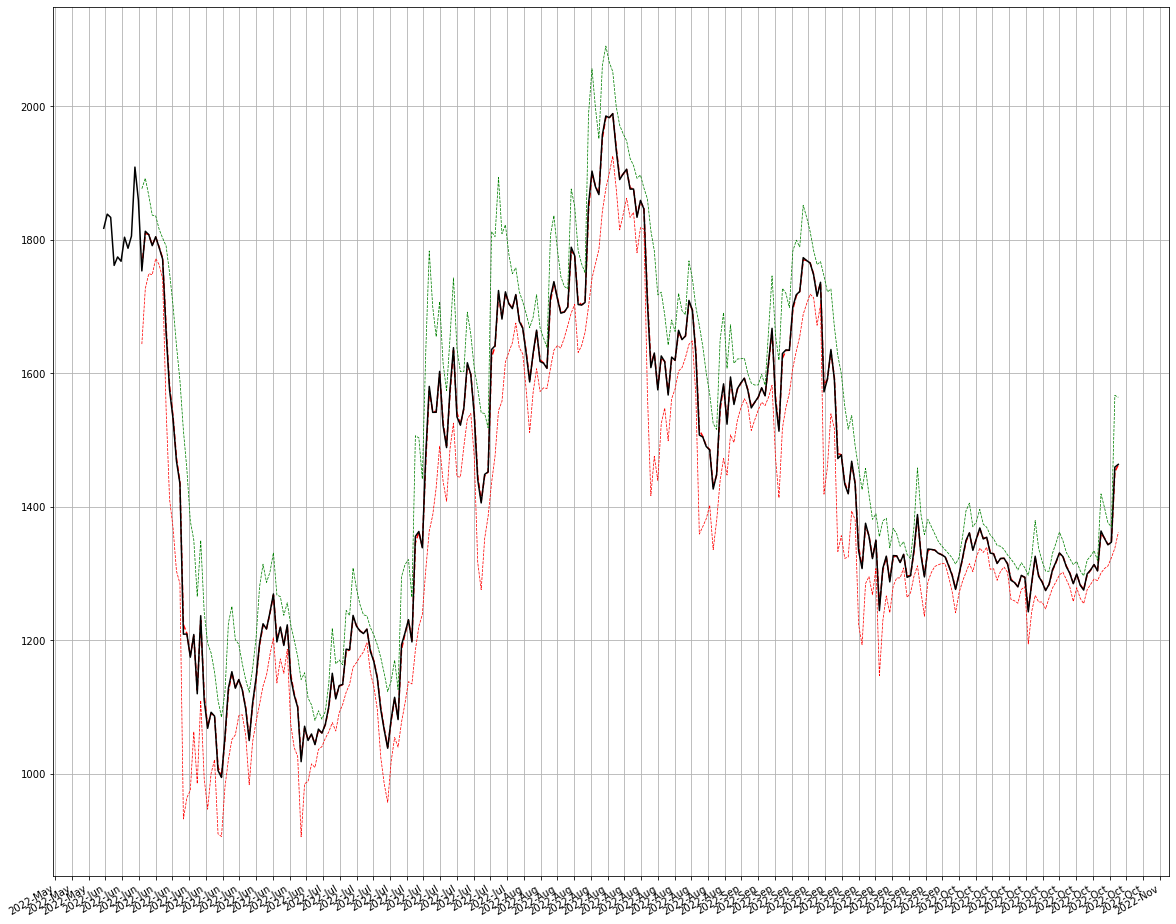

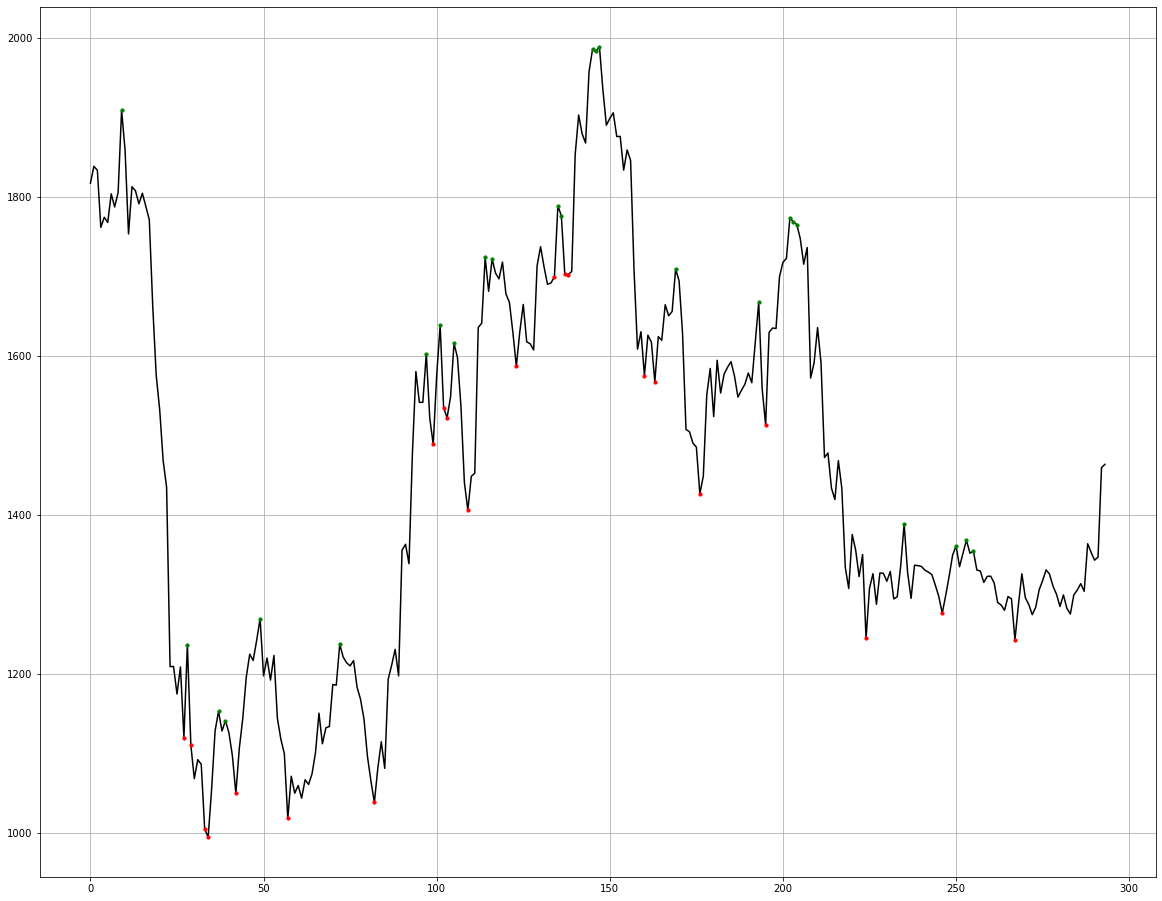

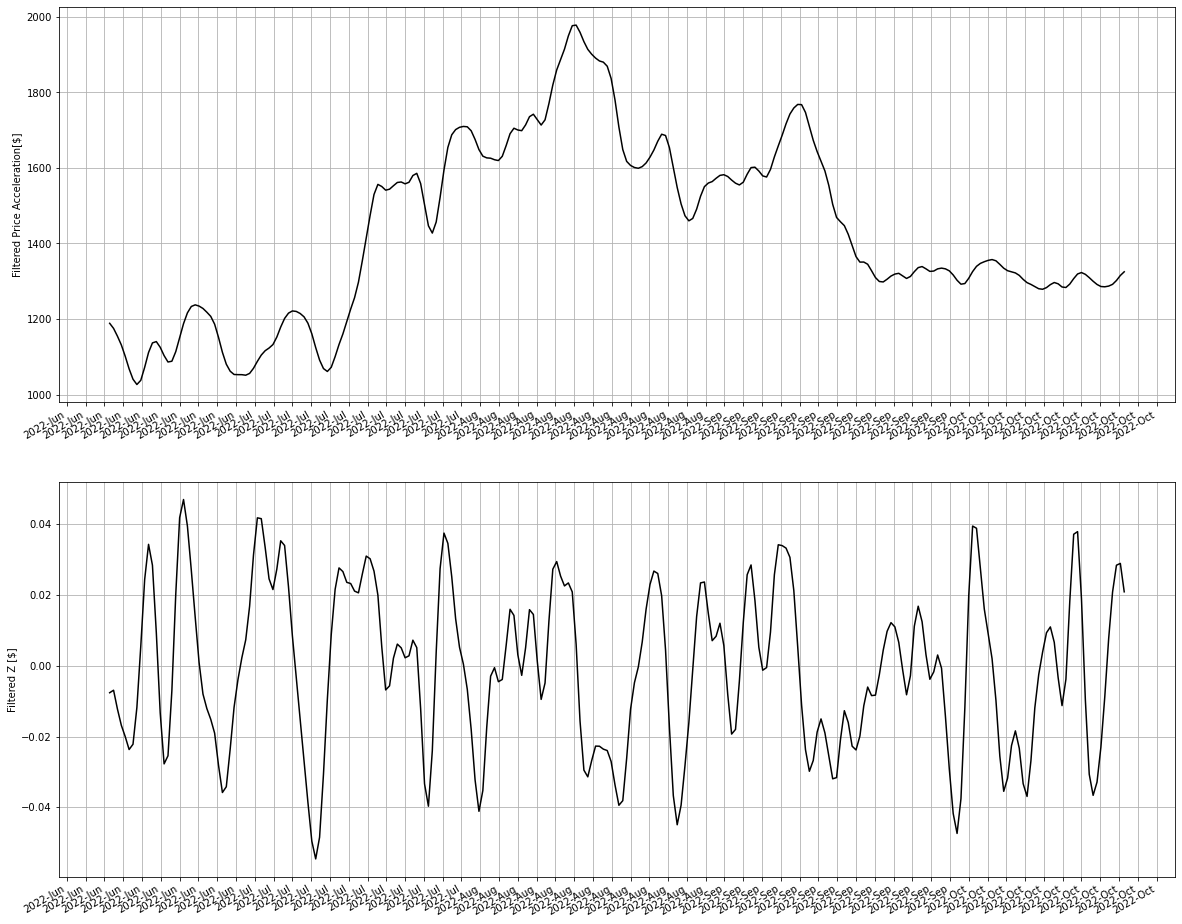

In [4]:

sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)
sdb.get_historical_klines()
sdb.make_features_and_labels()
(f1, a1), (f2, a2), (f3, axs) = sdb.plot_data()

In [5]:


# train_data.dropna(inplace=True)
# test_data.dropna(inplace=True)
# test_data.reindex(range(len(test_data))), train_data.reindex(range(len(train_data)))
sdb.train_data

,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,closes_ema,closes_std,closes_z,acc,filtered_acc,filtered_z
26,-1.065107,-0.809091,-0.991164,-0.926877,0.768668,0.270972,1.177813,0.843989,0.335102,-0.936150,1.930878,0.366754,-1.713763,-1.018450,-0.299441
27,-0.923289,-0.960888,-1.597164,-1.297859,2.409526,1.225834,2.733046,2.400978,1.228267,-1.276570,1.844152,-0.995906,-0.269177,-1.075219,-0.268236
28,-1.293700,-0.889374,-1.470463,-0.809217,3.378751,2.053290,3.340546,3.426786,2.105313,-0.839201,1.338091,1.505795,-1.112016,-1.162441,-0.503563
29,-0.805865,-0.856891,-1.261240,-1.336787,0.371389,-0.107273,0.503771,0.347391,-0.122819,-1.307049,1.455249,-1.488972,-1.548210,-1.260145,-0.706118
30,-1.332480,-1.299435,-1.437202,-1.513924,0.858167,0.130551,1.019090,0.872295,0.145392,-1.502553,1.447025,-0.747398,-1.332940,-1.386550,-0.846929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,-0.773674,-0.629587,-0.659901,-0.512248,0.103596,-0.150124,-0.091157,0.157186,-0.103776,-0.527591,0.204558,1.187683,-0.263163,-0.556700,0.230847
226,-0.509344,-0.475855,-0.595227,-0.436482,1.844329,1.347518,1.007477,1.883868,1.391599,-0.442535,-0.209094,0.712307,-0.730672,-0.526192,0.466486
227,-0.433703,-0.437237,-0.467938,-0.597580,0.356823,0.143440,-0.055357,0.312309,0.108122,-0.588428,-0.447048,-1.216663,-0.412597,-0.490922,0.574564
228,-0.594535,-0.518673,-0.554281,-0.432764,2.272585,1.709193,1.264099,2.265787,1.715306,-0.442848,-0.584499,1.375150,-0.375710,-0.468736,0.521543


In [6]:
sdb.test_data

,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,closes_ema,closes_std,closes_z,acc,filtered_acc,filtered_z
230,-0.431701,-0.479972,-0.366938,-0.476328,-0.558726,-0.630790,-0.808296,-0.593646,-0.662819,-0.474170,-1.073706,-0.671382,-0.267934,-0.488374,-0.014615
231,-0.473525,-0.529048,-0.332921,-0.424703,-1.298956,-1.276852,-1.425447,-1.287141,-1.271702,-0.428140,-1.172189,0.968040,-0.555416,-0.517777,-0.324778
232,-0.421902,-0.553791,-0.523036,-0.569053,-0.074632,-0.261103,-0.378302,-0.175012,-0.345831,-0.560752,-0.859757,-1.678680,-0.689815,-0.495320,-0.086927
233,-0.566097,-0.579729,-0.483728,-0.558276,0.256231,0.022289,-0.049686,0.272250,0.038276,-0.558925,-1.022018,-0.059259,-0.591381,-0.441979,0.529706
234,-0.555338,-0.516367,-0.418845,-0.396719,0.535777,0.298623,0.052160,0.582534,0.342461,-0.407171,-0.736818,1.753817,0.076162,-0.396742,0.779604
235,-0.394005,-0.269343,-0.258295,-0.176143,0.160091,0.057588,-0.168892,0.261716,0.149779,-0.190651,0.170454,1.382440,-0.281406,-0.385040,0.585526
236,-0.173752,-0.270660,-0.376765,-0.430383,1.680434,1.342024,0.762747,1.583665,1.265960,-0.415752,-0.212658,-1.550131,-0.710103,-0.410357,0.175130
237,-0.427573,-0.516532,-0.599427,-0.566379,1.356485,0.922701,0.436866,1.252355,0.841954,-0.557469,-0.135653,-1.069144,-0.372462,-0.438948,-0.131743
238,-0.563386,-0.451482,-0.420273,-0.391790,1.095778,0.782806,0.218130,1.148213,0.834720,-0.402454,-0.486168,1.349968,-0.373264,-0.435068,-0.039275
239,-0.389085,-0.467250,-0.336323,-0.394338,-0.113117,-0.246680,-0.534176,-0.113309,-0.246117,-0.395157,-0.803164,0.189987,-0.362559,-0.410650,0.171174


In [7]:
# X_train = torch.from_numpy(sdb.train_seqs).float().to(device='cuda')
# y_train = torch.from_numpy(sdb.train_tgt_seqs).float().to(device='cuda')

# X_test = torch.from_numpy(sdb.train_seqs).float().to(device='cuda')
# y_test = torch.from_numpy(sdb.train_tgt_seqs).float().to(device='cuda')


In [11]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5).cuda()
    self.fc2 = nn.Linear(5, 3).cuda()
    self.fc3 = nn.Linear(3, 3).cuda()

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x
  
 
    

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(n_features=15).to(device)

criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

X_train = torch.from_numpy(sdb.train_seqs).float().to(device)
y_train = torch.from_numpy(sdb.train_tgt_seqs).float().to(device)
X_test = torch.from_numpy(sdb.train_seqs).float().to(device)
y_test = torch.from_numpy(sdb.train_tgt_seqs).float().to(device)


# ann_viz(net, view=True)
X_train.shape, y_train.shape
y_train[-30:]

tensor([[ 0., -1.,  0.],
        [-1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0., -1.],
        [ 0., -1.,  0.]], device='cuda:0')

In [33]:
class LSTM(nn.Module):
  def __init__(self, input_size=15, hidden_layer_size=512, output_size=3):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

    self.linear = nn.Linear(hidden_layer_size, output_size).to(device)
    self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                        torch.zeros(1,1,self.hidden_layer_size).to(device))

  def forward(self, input_seq):
      lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
      predictions = self.linear(lstm_out.view(len(input_seq), -1))
      return predictions[-1]
    
model = LSTM().to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   
print(model)

LSTM(
  (lstm): LSTM(15, 100)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)


In [34]:
y_pred = model(X_train[3].to(device))

In [35]:
epochs = 150

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)
        print(y_pred)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

tensor([-0.0776, -0.0815,  0.0766], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0241, -0.0661, -0.0108], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0253, -0.0998, -0.0589], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0119, -0.1176, -0.0693], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0778, -0.1195, -0.1041], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1276, -0.1149, -0.1236], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1596, -0.1069, -0.1284], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1643, -0.1029, -0.1207], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1533, -0.0948, -0.1081], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1409, -0.0796, -0.0760], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.1111, -0.0685, -0.0557], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0797, -0.0613, -0.0395], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0600, -0.0553, -0.0293], devi

In [40]:
for i, e in enumerate(X_test.to(device)):
    y_pred = model(e)
    y_actual = y_test[i]
    print(y_pred, y_actual)
    
    print(loss_function(y_pred, y_actual))
# y_test[2]

tensor([ 0.1637,  0.0174, -1.0979], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0.,  0., -1.], device='cuda:0')
tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([ 0.1138, -1.0805, -0.0382], device='cuda:0', grad_fn=<SelectBackward0>) tensor([ 0., -1.,  0.], device='cuda:0')
tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.9292,  0.0070, -0.0879], device='cuda:0', grad_fn=<SelectBackward0>) tensor([-1.,  0.,  0.], device='cuda:0')
tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([ 0.0390, -0.0917, -0.1759], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0., 0., 0.], device='cuda:0')
tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([ 0.0120, -0.0161,  0.0366], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0., 0., 0.], device='cuda:0')
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.0027, -0.0132,  0.0055], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0., 0., 0.], 

In [31]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [32]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

ValueError: Using a target size (torch.Size([183, 3])) that is different to the input size (torch.Size([183, 7, 3])) is deprecated. Please ensure they have the same size.

In [33]:
model.train()
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

NameError: name 'model' is not defined

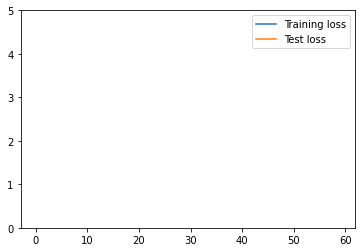

In [13]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [48]:
test_seq = X_test[:1]
y_test_pred = model(test_seq)
y_test_pred

tensor([[-0.3812, -0.2748,  0.2166]], device='cuda:0',
       grad_fn=<AddmmBackward0>)